# Overcome complex terrain with a hybrid controller

**Author:** Victor Alfred Stimpfling, Sibo Wang-Chen

**Note:** The code presented in this notebook has been simplified for simplicity and restructured for display in a notebook format. A more complete and better structured implementation can be found on the [examples folder of the FlyGym repository on GitHub](https://github.com/NeLy-EPFL/flygym/tree/main/flygym/examples/).

**Summary**: In this tutorial, we will illustrate how the CPG-based and rule-based controllers fail to produce robust locomotion over complex terrains. We will then build a combined CPG and sensory feedback-based hybrid controller that overcomes these deficits and generates more robust walking.

In the *[Controlling locomotion with CPGs](https://neuromechfly.org/tutorials/cpg_controller.html)* and *[Rule-based controller](https://neuromechfly.org/tutorials/rule_based_controller.html)* tutorials, we have demonstrated how different control strategies can lead to effective walking over simple, flat terrain. However, in the real world animals locomote over complex surfaces. To achieve this, animals likely use a combination of CPGs and sensory feedback to produce agile, adaptive body kinematics. To explore how sensory feedback can facilitate locomotion over rugged surfaces, we have developed three rugged terrain types which complement our baseline smooth terrain: one with gaps perpendicular to the initial heading of the fly, one with blocks of variable height, and one that is a mixture of these two. Using these new terrain types, we will now demonstrate how one can examine the efficacy of different bioinspired locomotor control strategies.

## Defining the arena

The environment that the fly is situated in is defined by the Arena class. So far, we have been using the default terrain: ``FlatTerrain``. Some other arenas are also included in FlyGym package, including ``GappedTerrain``, ``BlocksTerrain``, and ``MixedTerrain``. In future tutorials, we will introduce more arenas with sensory (visual, olfactory) features. The user can define custom arenas by inheriting from the ``flygym.mujoco.arena.BaseArena`` abstract class.

Let's start by defining a couple of terrains:

In [1]:
from flygym.arena import FlatTerrain, GappedTerrain, BlocksTerrain, MixedTerrain


def get_arena(arena_type):
    if arena_type == "flat":
        return FlatTerrain()
    elif arena_type == "gapped":
        return GappedTerrain()
    elif arena_type == "blocks":
        return BlocksTerrain()
    elif arena_type == "mixed":
        return MixedTerrain()
    else:
        raise ValueError(f"Unknown arena type: {arena_type}")

Let's put a fly into each of these terrains, run 0.01 seconds of the simulation so the fly can stabilize on the floor, and visualize how the fly looks in these different terrain types:

4it [00:14,  3.70s/it]


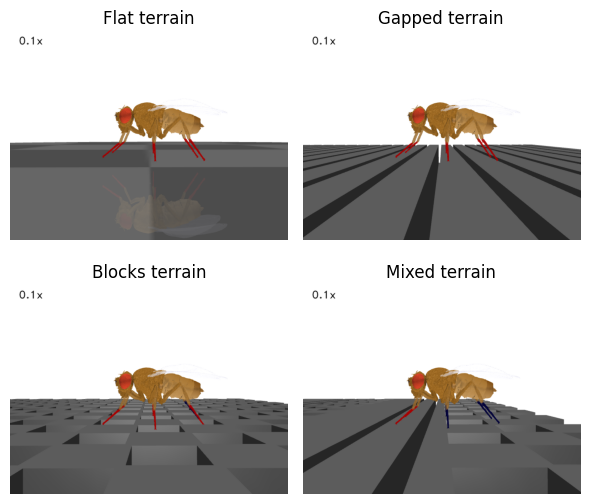

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm, trange
from flygym import Fly, Camera, SingleFlySimulation
from flygym.examples.locomotion import PreprogrammedSteps


preprogrammed_steps = PreprogrammedSteps()  # we will use the neutral pose from this

fig, axs = plt.subplots(2, 2, figsize=(6, 6), tight_layout=True)
terrain_types = ["flat", "gapped", "blocks", "mixed"]
for i, terrain_type in tqdm(enumerate(terrain_types)):
    ax = axs.flat[i]
    terrain = get_arena(terrain_type)
    # Initialize NeuroMechFly simulation
    fly = Fly(
        enable_adhesion=True,
        draw_adhesion=True,
        init_pose="stretch",
        control="position",
    )

    cam = Camera(fly=fly, play_speed=0.1)
    sim = SingleFlySimulation(
        fly=fly,
        cameras=[cam],
        timestep=1e-4,
        arena=terrain,
    )
    sim.reset()
    for _ in range(100):
        action = {
            "joints": preprogrammed_steps.default_pose,
            "adhesion": np.ones(6, dtype=np.int32),
        }
        sim.step(action)
        sim.render()
    ax.imshow(sim.cameras[0]._frames[-1])
    ax.axis("off")
    ax.set_title(f"{terrain_type.title()} terrain")

fig.savefig("./outputs/complex_terrain_overview.png")

## Basic CPG-based and rule-based controllers

Do the CPG-based and rule-based controllers work well over complex terrain? Let's run the simulation for 0.5 seconds using each of these controllers on each of the different terrain types:

In [3]:
from flygym.examples.locomotion.cpg_controller import CPGNetwork, run_cpg_simulation
from flygym.examples.locomotion.rule_based_controller import (
    RuleBasedController,
    construct_rules_graph,
    run_rule_based_simulation,
)

run_time = 1.0
timestep = 1e-4

for controller_name in ["CPG-based", "Rule-based"]:
    for terrain_name in terrain_types:
        print(f"* Running {controller_name} controller on {terrain_name} terrain")

        terrain = get_arena(terrain_name)

        # Initialize the simulation
        fly = Fly(
            enable_adhesion=True,
            draw_adhesion=True,
            init_pose="stretch",
            control="position",
        )

        cam = Camera(fly=fly, play_speed=0.1)
        sim = SingleFlySimulation(
            fly=fly,
            cameras=[cam],
            timestep=1e-4,
            arena=terrain,
        )
        sim.reset()

        if controller_name == "CPG-based":
            intrinsic_freqs = np.ones(6) * 12
            intrinsic_amps = np.ones(6) * 1
            phase_biases = np.pi * np.array(
                [
                    [0, 1, 0, 1, 0, 1],
                    [1, 0, 1, 0, 1, 0],
                    [0, 1, 0, 1, 0, 1],
                    [1, 0, 1, 0, 1, 0],
                    [0, 1, 0, 1, 0, 1],
                    [1, 0, 1, 0, 1, 0],
                ]
            )
            coupling_weights = (phase_biases > 0) * 10
            convergence_coefs = np.ones(6) * 20
            cpg_network = CPGNetwork(
                timestep=timestep,
                intrinsic_freqs=intrinsic_freqs,
                intrinsic_amps=intrinsic_amps,
                coupling_weights=coupling_weights,
                phase_biases=phase_biases,
                convergence_coefs=convergence_coefs,
            )
            run_cpg_simulation(sim, cpg_network, preprogrammed_steps, run_time)
        elif controller_name == "Rule-based":
            weights = {
                "rule1": -10,
                "rule2_ipsi": 2.5,
                "rule2_contra": 1,
                "rule3_ipsi": 3.0,
                "rule3_contra": 2.0,
            }
            rules_graph = construct_rules_graph()
            controller = RuleBasedController(
                timestep=timestep,
                rules_graph=rules_graph,
                weights=weights,
                preprogrammed_steps=preprogrammed_steps,
            )
            run_rule_based_simulation(sim, controller, run_time)
        else:
            raise ValueError(f"Unknown controller: {controller}")

        x_pos = sim.get_observation()["fly"][0, 0]
        print(f"Final x position: {x_pos:.4f} mm")

        cam.save_video(f"./outputs/{controller_name}_{terrain_name}.mp4")

* Running CPG-based controller on flat terrain


100%|██████████| 10000/10000 [00:24<00:00, 416.41it/s]


Final x position: 13.8034 mm
* Running CPG-based controller on gapped terrain


100%|██████████| 10000/10000 [01:22<00:00, 121.74it/s]


Final x position: 4.3090 mm
* Running CPG-based controller on blocks terrain


100%|██████████| 10000/10000 [00:40<00:00, 246.66it/s]


Final x position: 9.0447 mm
* Running CPG-based controller on mixed terrain


100%|██████████| 10000/10000 [00:53<00:00, 188.12it/s]


Final x position: 6.3057 mm
* Running Rule-based controller on flat terrain


100%|██████████| 10000/10000 [00:26<00:00, 371.25it/s]


Final x position: 6.2626 mm
* Running Rule-based controller on gapped terrain


100%|██████████| 10000/10000 [01:15<00:00, 133.27it/s]


Final x position: 4.4435 mm
* Running Rule-based controller on blocks terrain


100%|██████████| 10000/10000 [00:41<00:00, 242.86it/s]


Final x position: 4.6136 mm
* Running Rule-based controller on mixed terrain


100%|██████████| 10000/10000 [00:52<00:00, 190.96it/s]


Final x position: 5.2407 mm


Though we have only tested one initial condition (spawn position, controller) per case, we can already begin to observe that the CPG-based and rule-based controllers may not be very robust over complex terrain. In fact, if we run 20 initial conditions for 1 second each, we get a result like the one reported in the NeuroMechFly v2 paper (Wang-Chen et al., 2023):

<img src="https://github.com/NeLy-EPFL/_media/blob/main/flygym/cpg_rule_based_comparison.png?raw=true" alt="cpg_rule_based_comparison" width="800"/>

We can look more closely at some examples of failed locomotion:

*CPG-based controller over gapped terrain:*

<video width="400" controls>
  <source src="https://raw.githubusercontent.com/NeLy-EPFL/_media/main/flygym/CPG-based_gapped.mp4" type="video/mp4">
</video>

*Rule-based controller over gapped terrain:*

<video width="400" controls>
  <source src="https://raw.githubusercontent.com/NeLy-EPFL/_media/main/flygym/Rule-based_gapped.mp4" type="video/mp4">
</video>

In the next section, we will show that by combining CPGs with sensory feedback, we can build a more robust controller.

## Building a hybrid controller

Now, we will build a hybrid controller that integrates both feedforward oscillators as well as feedback-based mechanisms that reposition the legs  if they get stuck. As described in the NeuroMechFly v2 paper, we will detect the following conditions:

1. **Retraction:** In principle, with the tripod gait, there should always be three legs on the ground. Therefore, if any leg is extended farther than the third most extended leg in the z-direction, this leg may be stuck in a hole. This rule will lift the leg to recover it from a stuck position.
2. **Stumbling:** In principle, only the tip of the tarsus of each leg should contact with the ground. Therefore, we will consider the fly as stumbling if the tibia or upper tarsal segments (1 and 2) collide with the ground resulting in a supra-threshold force against the direction of the fly’s heading. To correct for stumbling we will lift the stumbling leg.

To implement these rules, we will create a variable for each rule that keeps track of the extent to which a given leg should be lifted:

In [4]:
retraction_correction = np.zeros(6)
stumbling_correction = np.zeros(6)

retraction_persistance_counter = np.zeros(6)

We will also define a vector representing how each DoF should be adjusted to implement leg lifting. We will call this $\vec{v}_\text{leg}$.

In [5]:
correction_vectors = {
    # "leg pos": (Coxa, Coxa_roll, Coxa_yaw, Femur, Femur_roll, Tibia, Tarsus1)
    # unit: radian
    "F": np.array([-0.03, 0, 0, -0.03, 0, 0.03, 0.03]),
    "M": np.array([-0.015, 0.001, 0.025, -0.02, 0, -0.02, 0.0]),
    "H": np.array([0, 0, 0, -0.02, 0, 0.01, -0.02]),
}

That is, when the leg should be lifted, we will increment the joint angles on this leg by $\vec{v}_\text{leg}$ scaled by a factor defining the extent of correction. When the condition is no longer met, we will reduce the correction term until it reaches zero (ie. with no adjustment) so that the target angles applied to the simulator are those suggested by the corresponding CPGs.

Next, we need to define the factor defining the extent of correction. Recall that we will progressively lift the leg when an adjustment is necessary. Therefore, let's also define the rate of adjustment $k_\text{inc}$ when the condition is met and the rate of recovery $k_\text{dec}$ when the condition is no longer met:

In [6]:
correction_rates = {
    # "rule": (increment rate, decrement rate). unit: 1/sec
    "retraction": (800, 700),
    "stumbling": (2200, 1800),
}

Concretely, we will initialize the amount of correction $c$ to 0. This variable is unitless. For every $t$ amount of time that the condition is met, we increment $c$ by $k_\text{inc}t$ where $k_\text{inc}$ is the appropriate correction rate. Similarly, for every $t$ amount of time that the condition is no longer met, we will decrement $c$ by $k_\text{dec}t$ until it reaches 0. We will therefore adjust the leg joint angles by adding $c\vec{v}_\text{leg}$ to it.

We should also define a threshold for the stumbling force. Note that a negative number indicates a force against the direction in which the fly is facing:

In [7]:
stumbling_force_threshold = -1

Next, we will define the underlying CPG network as we did in the [tutorial on CPG-based control](https://neuromechfly.org/tutorials/cpg_controller.html):

In [8]:
run_time = 1
timestep = 1e-4

# define parameters for persitance and cap the increment
max_increment = 80 / 1e-4
retraction_persistance = 20 / 1e-4
persistance_init_thr = 20 / 1e-4

right_leg_inversion = [1, -1, -1, 1, -1, 1, 1]

# Initialize CPG network
intrinsic_freqs = np.ones(6) * 12
intrinsic_amps = np.ones(6) * 1
phase_biases = np.pi * np.array(
    [
        [0, 1, 0, 1, 0, 1],
        [1, 0, 1, 0, 1, 0],
        [0, 1, 0, 1, 0, 1],
        [1, 0, 1, 0, 1, 0],
        [0, 1, 0, 1, 0, 1],
        [1, 0, 1, 0, 1, 0],
    ]
)
coupling_weights = (phase_biases > 0) * 10
convergence_coefs = np.ones(6) * 20
cpg_network = CPGNetwork(
    timestep=1e-4,
    intrinsic_freqs=intrinsic_freqs,
    intrinsic_amps=intrinsic_amps,
    coupling_weights=coupling_weights,
    phase_biases=phase_biases,
    convergence_coefs=convergence_coefs,
)

Similarly, let's define the preprogrammed steps:

In [9]:
# Initialize preprogrammed steps
preprogrammed_steps = PreprogrammedSteps()

In our hybrid controller the action performed by a leg stuck in a hole or coliding with an edge depends on the step phase. Upon on of the rules activation, when the leg is in stance and adhesion is on, the leg can be slightly more extended to facilitate the other legs to overcome the obstacle. When the leg is in swing and one of the leg is active, the leg can be retracted higher to help overcoming the obstacle. Here we define the phasic gain that will help implementing this behavior.

<>:40: SyntaxWarning: invalid escape sequence '\p'
<>:40: SyntaxWarning: invalid escape sequence '\p'
<>:40: SyntaxWarning: invalid escape sequence '\p'
<>:40: SyntaxWarning: invalid escape sequence '\p'
<>:40: SyntaxWarning: invalid escape sequence '\p'
<>:40: SyntaxWarning: invalid escape sequence '\p'
<>:40: SyntaxWarning: invalid escape sequence '\p'
<>:40: SyntaxWarning: invalid escape sequence '\p'
/tmp/ipykernel_2110802/4082873201.py:40: SyntaxWarning: invalid escape sequence '\p'
  ["0", "$\pi$", "$2\pi$", "$3\pi$", "$4\pi$"],
/tmp/ipykernel_2110802/4082873201.py:40: SyntaxWarning: invalid escape sequence '\p'
  ["0", "$\pi$", "$2\pi$", "$3\pi$", "$4\pi$"],
/tmp/ipykernel_2110802/4082873201.py:40: SyntaxWarning: invalid escape sequence '\p'
  ["0", "$\pi$", "$2\pi$", "$3\pi$", "$4\pi$"],
/tmp/ipykernel_2110802/4082873201.py:40: SyntaxWarning: invalid escape sequence '\p'
  ["0", "$\pi$", "$2\pi$", "$3\pi$", "$4\pi$"],


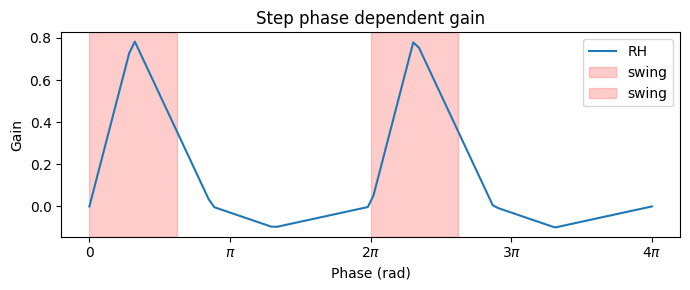

In [10]:
from scipy.interpolate import interp1d

step_phase_gain = {}

for leg in preprogrammed_steps.legs:
    swing_start, swing_end = preprogrammed_steps.swing_period[leg]

    step_points = [
        swing_start,
        np.mean([swing_start, swing_end]),
        swing_end + np.pi / 4,
        np.mean([swing_end, 2 * np.pi]),
        2 * np.pi,
    ]
    preprogrammed_steps.swing_period[leg] = (swing_start, swing_end + np.pi / 4)
    increment_vals = [0, 0.8, 0, -0.1, 0]

    step_phase_gain[leg] = interp1d(
        step_points, increment_vals, kind="linear", fill_value="extrapolate"
    )

fig = plt.figure(figsize=(7, 3), tight_layout=True)
step_phase = np.linspace(0, 4 * np.pi, 100)

plt.plot(step_phase, step_phase_gain[leg](step_phase % (2 * np.pi)), label=leg)
for i in range(2):
    plt.axvspan(
        swing_start + i * 2 * np.pi,
        swing_end + i * 2 * np.pi,
        color="red",
        alpha=0.2,
        label="swing",
    )
plt.legend()
plt.xlabel("Phase (rad)")
plt.ylabel("Gain")
# label in pi
plt.xticks(
    [0, np.pi, 2 * np.pi, 3 * np.pi, 4 * np.pi],
    ["0", "$\pi$", "$2\pi$", "$3\pi$", "$4\pi$"],
)
plt.title("Step phase dependent gain")
plt.savefig("outputs/step_phase_dependent_gain.png")

... and the NeuroMechFly simulation over mixed terrain. We will enable contact detection for all tibial and tarsal segments to achieve stumbling detection:

In [11]:
# Initialize NeuroMechFly simulation
# Initialize the simulation

contact_sensor_placements = [
    f"{leg}{segment}"
    for leg in preprogrammed_steps.legs
    for segment in ["Tibia", "Tarsus1", "Tarsus2", "Tarsus3", "Tarsus4", "Tarsus5"]
]

np.random.seed(0)
fly = Fly(
    enable_adhesion=True,
    draw_adhesion=True,
    init_pose="stretch",
    control="position",
    contact_sensor_placements=contact_sensor_placements,
)

cam = Camera(fly=fly, play_speed=0.1)
arena = MixedTerrain()
sim = SingleFlySimulation(
    fly=fly,
    cameras=[cam],
    timestep=1e-4,
    arena=arena,
)
_ = sim.reset()

Let's build a dictionary containing the indices of the contact sensors on each leg. These will be used to detect stumbling:

In [12]:
detected_segments = ["Tibia", "Tarsus1", "Tarsus2"]
stumbling_sensors = {leg: [] for leg in preprogrammed_steps.legs}
for i, sensor_name in enumerate(fly.contact_sensor_placements):
    leg = sensor_name.split("/")[1][:2]  # sensor_name: eg. "Animat/LFTarsus1"
    segment = sensor_name.split("/")[1][2:]
    if segment in detected_segments:
        stumbling_sensors[leg].append(i)
stumbling_sensors = {k: np.array(v) for k, v in stumbling_sensors.items()}

As a sanity check, let's make sure that the number of stumble sensors per leg is as expected:

In [13]:
if any(v.size != len(detected_segments) for v in stumbling_sensors.values()):
    raise RuntimeError(
        "Contact detection must be enabled for all tibia, tarsus1, and tarsus2 "
        "segments for stumbling detection."
    )

We are now ready to write the main simulation loop. We will implement and execute the entire loop before explaining its constituent components:

In [14]:
target_num_steps = int(run_time / sim.timestep)
obs_list = []

physics_error = False

obs, _ = sim.reset()

for k in trange(target_num_steps):
    # retraction rule: does a leg need to be retracted from a hole?
    end_effector_z_pos = obs["fly"][0][2] - obs["end_effectors"][:, 2]
    end_effector_z_pos_sorted_idx = np.argsort(end_effector_z_pos)
    end_effector_z_pos_sorted = end_effector_z_pos[end_effector_z_pos_sorted_idx]
    if end_effector_z_pos_sorted[-1] > end_effector_z_pos_sorted[-3] + 0.05:
        leg_to_correct_retraction = end_effector_z_pos_sorted_idx[-1]
        if (
            retraction_correction[leg_to_correct_retraction]
            > persistance_init_thr * sim.timestep
        ):
            retraction_persistance_counter[leg_to_correct_retraction] = 1
    else:
        leg_to_correct_retraction = None

    # update persistance counter
    retraction_persistance_counter[retraction_persistance_counter > 0] += 1
    retraction_persistance_counter[
        retraction_persistance_counter > retraction_persistance * sim.timestep
    ] = 0

    cpg_network.step()
    joints_angles = []
    adhesion_onoff = []

    all_net_corrections = []

    for i, leg in enumerate(preprogrammed_steps.legs):
        # update amount of retraction correction
        if (
            i == leg_to_correct_retraction or retraction_persistance_counter[i] > 0
        ):  # lift leg
            increment = correction_rates["retraction"][0] * sim.timestep
            retraction_correction[i] += increment
            sim.fly.change_segment_color(sim.physics, f"{leg}Tibia", (1, 0, 0, 1))
        else:  # condition no longer met, lower leg
            decrement = correction_rates["retraction"][1] * sim.timestep
            retraction_correction[i] = max(0, retraction_correction[i] - decrement)
            sim.fly.change_segment_color(sim.physics, f"{leg}Tibia", (0.5, 0.5, 0.5, 1))

        # update amount of stumbling correction
        contact_forces = obs["contact_forces"][stumbling_sensors[leg], :]
        fly_orientation = obs["fly_orientation"]
        # force projection should be negative if against fly orientation
        force_proj = np.dot(contact_forces, fly_orientation)
        if (force_proj < stumbling_force_threshold).any():
            increment = correction_rates["stumbling"][0] * sim.timestep
            stumbling_correction[i] += increment
            if retraction_correction[i] <= 0:
                sim.fly.change_segment_color(sim.physics, f"{leg}Femur", (1, 0, 0, 1))
        else:
            decrement = correction_rates["stumbling"][1] * sim.timestep
            stumbling_correction[i] = max(0, stumbling_correction[i] - decrement)
            sim.fly.change_segment_color(sim.physics, f"{leg}Femur", (0.5, 0.5, 0.5, 1))

        # retraction correction is prioritized
        if retraction_correction[i] > 0:
            net_correction = retraction_correction[i]
            stumbling_correction[i] = 0
        else:
            net_correction = stumbling_correction[i]

        # get target angles from CPGs and apply correction
        my_joints_angles = preprogrammed_steps.get_joint_angles(
            leg, cpg_network.curr_phases[i], cpg_network.curr_magnitudes[i]
        )
        net_correction = np.clip(net_correction, 0, max_increment * sim.timestep)
        if leg[0] == "R":
            net_correction *= right_leg_inversion[i]

        # apply phase dependant gain
        net_correction *= step_phase_gain[leg](cpg_network.curr_phases[i] % (2 * np.pi))

        my_joints_angles += net_correction * correction_vectors[leg[1]]
        joints_angles.append(my_joints_angles)

        all_net_corrections.append(net_correction)

        # get adhesion on/off signal
        my_adhesion_onoff = preprogrammed_steps.get_adhesion_onoff(
            leg, cpg_network.curr_phases[i]
        )

        adhesion_onoff.append(my_adhesion_onoff)

    action = {
        "joints": np.array(np.concatenate(joints_angles)),
        "adhesion": np.array(adhesion_onoff).astype(int),
    }
    obs, reward, terminated, truncated, info = sim.step(action)
    obs["net_correction"] = all_net_corrections
    obs_list.append(obs)
    sim.render()

100%|██████████| 10000/10000 [00:54<00:00, 184.64it/s]


In [15]:
print(f"Simulation terminated: {obs_list[-1]['fly'][0] - obs_list[0]['fly'][0]}")

Simulation terminated: [10.464745    2.3659656  -0.44085807]


At each simulation time step, we first check whether the retraction rule is met. This depends on whether any leg is extended further than the third most extended leg in the z-direction by a margin of 0.05 mm. This margin is important because contact calculations in the physics simulator are imperfect sometimes causing the leg to penetrate the floor by a small amount. If two legs meet this condition, only the most extended leg is corrected:

```Python
    # retraction rule: does a leg need to be retracted from a hole?
    end_effector_z_pos = obs["fly"][0][2] - obs["end_effectors"][:, 2]
    end_effector_z_pos_sorted_idx = np.argsort(end_effector_z_pos)
    end_effector_z_pos_sorted = end_effector_z_pos[end_effector_z_pos_sorted_idx]
   if end_effector_z_pos_sorted[-1] > end_effector_z_pos_sorted[-3] + 0.05:
        leg_to_correct_retraction = end_effector_z_pos_sorted_idx[-1]
        if retraction_correction[leg_to_correct_retraction] > persistance_init_thr*sim.timestep:
            retraction_persistance_counter[leg_to_correct_retraction] = 1
    else:
        leg_to_correct_retraction = None

    # update persistance counter
    retraction_persistance_counter[retraction_persistance_counter > 0] += 1
    retraction_persistance_counter[
        retraction_persistance_counter > retraction_persistance*sim.timestep
    ] = 0
```

We also implemented persistance so that the rule is still active for a few steps after the condition is no longer met. The leg's protraction should be maintained for some time to avoid it falling back into the hole.

Then, have an inner loop that iterates over all legs. The joint angles and adhesion on/off signals are calculated here. We first update the amount of correction :math:`c` for the retraction rule:

```Python
        # update amount of retraction correction
        if (
            i == leg_to_correct_retraction or retraction_persistance_counter[i] > 0
        ):  # lift leg
            increment = correction_rates["retraction"][0] * nmf.timestep
            retraction_correction[i] += increment
            nmf.change_segment_color(f"{leg}Tibia", (1, 0, 0, 1))
        else:  # condition no longer met, lower leg
            decrement = correction_rates["retraction"][1] * nmf.timestep
            retraction_correction[i] = max(0, retraction_correction[i] - decrement)
            nmf.change_segment_color(f"{leg}Tibia", (0.5, 0.5, 0.5, 1))
```

Similarly, we update the correction amount $c$ for the stumbling rule:

```Python
        # update amount of stumbling correction
        contact_forces = obs["contact_forces"][stumbling_sensors[leg], :]
        fly_orientation = obs["fly_orientation"]
        # force projection should be negative if against fly orientation
        force_proj = np.dot(contact_forces, fly_orientation)
        if (force_proj < stumbling_force_threshold).any():
            increment = correction_rates["stumbling"][0] * nmf.timestep
            stumbling_correction[i] += increment
            if retraction_correction[i] <= 0:
                nmf.change_segment_color(f"{leg}Femur", (1, 0, 0, 1))
        else:
            decrement = correction_rates["stumbling"][1] * nmf.timestep
            stumbling_correction[i] = max(0, stumbling_correction[i] - decrement)
            nmf.change_segment_color(f"{leg}Femur", (0.5, 0.5, 0.5, 1))
```

In the case that both rules are active for the same leg, we will only apply the retraction correction:

```Python
        # retraction correction is prioritized
        if retraction_correction[i] > 0:
            net_correction = retraction_correction[i]
            
        else:
            net_correction = stumbling_correction[i]
```

Let’s first obtain the initial joint angles based purely on the CPG phase and preprogrammed step. Then, we will apply the lifting correction:

```Python
        # get target angles from CPGs and apply correction
        my_joints_angles = preprogrammed_steps.get_joint_angles(
            leg, cpg_network.curr_phases[i], cpg_network.curr_magnitudes[i]
        )
        my_joints_angles += net_correction * correction_vectors[leg[1]]
        joints_angles.append(my_joints_angles)
```

The net correction for roll and yaw angles needs to be inverted for the resulting action to be symmetrical

```Python
     net_correction = np.clip(net_correction, 0, max_increment*sim.timestep)
        if leg[0] == "R":
            net_correction *= right_leg_inversion[i]
```
The net correction needs to be reversed to lead to retraction or protraction if during swing or stance phase

```Python
        # apply phase dependant gain
        net_correction *= step_phase_gain[leg](cpg_network.curr_phases[i] % (2*np.pi))
```

Finally, we can get the adhesion on/off signal based on the leg phase as well:

```Python
        # get adhesion on/off signal
        my_adhesion_onoff = preprogrammed_steps.get_adhesion_onoff(
            leg, cpg_network.curr_phases[i]
        )
        adhesion_onoff.append(my_adhesion_onoff)
```

We now have all we need to feed the action into the NeuroMechFly simulation. Don’t forget to call `.render()` to record the video correctly.

```Python
    action = {
        "joints": np.array(np.concatenate(joints_angles)),
        "adhesion": np.array(adhesion_onoff).astype(int),
    }
    obs, reward, terminated, truncated, info = nmf.step(action)
    nmf.render()
```


Let's visualize the results:

In [16]:
cam.save_video("./outputs/hybrid_controller_mixed_terrain.mp4")

<video width="400" controls>
  <source src="https://raw.githubusercontent.com/NeLy-EPFL/_media/main/flygym/hybrid_controller_mixed_terrain.mp4" type="video/mp4">
</video>

Even based on this single example, this hybrid controller looks better than the CPG-based or rule-based controller. Indeed, we obtained the following results by running 20 simulations for each controller over each terrain type with different initial conditions. These show that a hybrid controller outperforms the other two controllers (see the NeuroMechFly v2 paper for details):

<img src="https://github.com/NeLy-EPFL/_media/blob/main/flygym/cpg_rule_based_hybrid_comparison.png?raw=true" alt="cpg_rule_based_comparison" width="800"/>

These results demonstrate how rugged terrain can expose failure modes for controllers that otherwise work well on flat terrain, and how you can use NeuroMechFly to benchmark different control strategies that go beyond the classical dichotomy of CPG-based versus rule-based control.

In the next tutorial, we will refactor our hybrid controller code into a Python class that implements the Gym interface. This will allow us to show how to build control models with different degrees of abstraction and preprogrammed computations.